# 8. Project: Markov Simulation

### Goal of this project: write a program that simulates customer behaviour in a supermarket.

Task:
1. explore the data (includes pandas wrangling)
2. calculate transition probabilities (a 5x5 matrix)
3. implement a customer class
4. run a MCMC simulation for a single customer
5. extend the simulation to multiple customers

## <<< Data Exploration >>>

In [365]:
#!pip install numpy

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns

In [167]:
mon = pd.read_csv("data/monday.csv", sep=";", index_col=[0], parse_dates=True)
tue = pd.read_csv("data/tuesday.csv", sep=";", index_col=[0], parse_dates=True)
wed = pd.read_csv("data/wednesday.csv", sep=";", index_col=[0], parse_dates=True)
thr = pd.read_csv("data/thursday.csv", sep=";", index_col=[0], parse_dates=True)
fri = pd.read_csv("data/friday.csv", sep=";", index_col=[0], parse_dates=True)

In [168]:
mon.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


In [169]:
# Add a unique identifier for the customers throughout the weeks
mon["id"] = "mon" + "-" + mon.customer_no.astype(str)
tue["id"] = "tue" + "-" + tue.customer_no.astype(str)
wed["id"] = "wed" + "-" + wed.customer_no.astype(str)
thr["id"] = "thr" + "-" + thr.customer_no.astype(str)
fri["id"] = "fri" + "-" + fri.customer_no.astype(str)

In [170]:
fri

,customer_no,location,id
timestamp,,,
2019-09-06 07:00:00,1,dairy,fri-1
2019-09-06 07:00:00,2,drinks,fri-2
2019-09-06 07:00:00,3,fruit,fri-3
2019-09-06 07:01:00,2,checkout,fri-2
2019-09-06 07:01:00,4,drinks,fri-4
...,...,...,...
2019-09-06 21:50:00,1500,dairy,fri-1500
2019-09-06 21:50:00,1507,checkout,fri-1507
2019-09-06 21:50:00,1508,checkout,fri-1508


In [171]:
df = pd.concat([mon, tue, wed, thr, fri], axis=0)

In [172]:
df.drop(["customer_no"], axis=1, inplace=True)

In [173]:
df

,location,id
timestamp,,
2019-09-02 07:03:00,dairy,mon-1
2019-09-02 07:03:00,dairy,mon-2
2019-09-02 07:04:00,dairy,mon-3
2019-09-02 07:04:00,dairy,mon-4
2019-09-02 07:04:00,spices,mon-5
...,...,...
2019-09-06 21:50:00,dairy,fri-1500
2019-09-06 21:50:00,checkout,fri-1507
2019-09-06 21:50:00,checkout,fri-1508


### 1. Calculate the total number of customers in each section


In [174]:
df.groupby(["location"]).count()

,id
location,
checkout,7417
dairy,4679
drinks,3905
fruit,5122
spices,3754


### 2. Calculate the total number of customers in each section over time


In [175]:
df["hour"] = df.index.hour
df["time"] = df.index.time
df["min"] = df.index.minute
df["weekday"] = df.index.day_name()


<AxesSubplot:xlabel='hour', ylabel='count'>

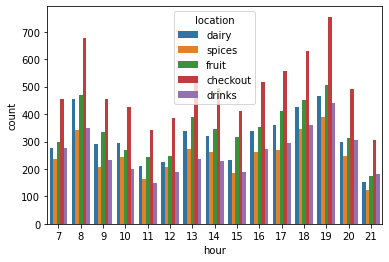

In [176]:
sns.countplot(data=df, x="hour", hue="location")


In [177]:
df.groupby([df['hour'], 'weekday'])['id'].count().unstack()

weekday,Friday,Monday,Thursday,Tuesday,Wednesday
hour,,,,,
7,305,317,315,328,279
8,469,364,447,463,547
9,254,308,323,262,373
10,296,282,303,267,283
11,275,189,227,133,287
12,283,265,234,199,271
13,357,412,297,330,358
14,359,305,299,343,344
15,258,342,266,223,246


### 3. Display the number of customers at checkout over time


<AxesSubplot:xlabel='hour', ylabel='count'>

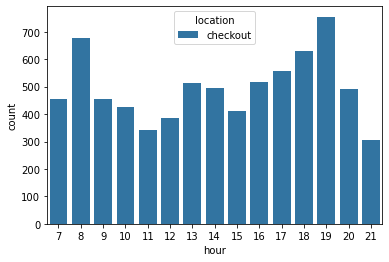

In [178]:
sns.countplot(data=df.loc[df["location"] == "checkout"], x="hour", hue = "location")

### 4. Calculate the time each customer spent in the market


In [179]:
df.head()

,location,id,hour,time,min,weekday
timestamp,,,,,,
2019-09-02 07:03:00,dairy,mon-1,7,07:03:00,3,Monday
2019-09-02 07:03:00,dairy,mon-2,7,07:03:00,3,Monday
2019-09-02 07:04:00,dairy,mon-3,7,07:04:00,4,Monday
2019-09-02 07:04:00,dairy,mon-4,7,07:04:00,4,Monday
2019-09-02 07:04:00,spices,mon-5,7,07:04:00,4,Monday


In [180]:
df.reset_index()

,timestamp,location,id,hour,time,min,weekday
0,2019-09-02 07:03:00,dairy,mon-1,7,07:03:00,3,Monday
1,2019-09-02 07:03:00,dairy,mon-2,7,07:03:00,3,Monday
2,2019-09-02 07:04:00,dairy,mon-3,7,07:04:00,4,Monday
3,2019-09-02 07:04:00,dairy,mon-4,7,07:04:00,4,Monday
4,2019-09-02 07:04:00,spices,mon-5,7,07:04:00,4,Monday
...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,dairy,fri-1500,21,21:50:00,50,Friday
24873,2019-09-06 21:50:00,checkout,fri-1507,21,21:50:00,50,Friday
24874,2019-09-06 21:50:00,checkout,fri-1508,21,21:50:00,50,Friday
24875,2019-09-06 21:50:00,drinks,fri-1509,21,21:50:00,50,Friday


In [362]:
customer_time = []

# list of customers
unique_customer = df["id"].unique()
# how much time has every customer spent in the supermarket?
for customer in unique_customer:
    temp = df.loc[df["id"] == customer]
    starttime = temp.index[0]
    endtime = temp.index[-1]
    timetemp = (endtime - starttime) / pd.Timedelta(minutes=1)

    customer_time.append(
        {
            "id": customer,
            "timespent_minutes": timetemp
        }
    )

presence = pd.DataFrame(customer_time)

In [182]:
presence

,id,timespent_minutes
0,mon-1,2.0
1,mon-2,3.0
2,mon-3,2.0
3,mon-4,4.0
4,mon-5,1.0
...,...,...
7440,fri-1506,0.0
7441,fri-1507,2.0
7442,fri-1508,2.0
7443,fri-1509,0.0


In [183]:
presence.sort_values("timespent_minutes")

,id,timespent_minutes
7444,fri-1510,0.0
5932,thr-1533,0.0
5931,thr-1532,0.0
1446,mon-1447,0.0
1444,mon-1445,0.0
...,...,...
7172,fri-1238,49.0
3578,wed-710,51.0
665,mon-666,51.0
6036,fri-102,52.0


### 5. Calculate the total number of customers in the supermarket over time

<AxesSubplot:xlabel='time'>

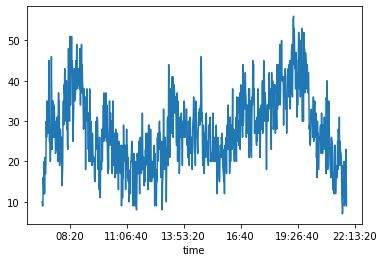

In [184]:
df.set_index("time").groupby("time")["id"].count().plot()

## <<< Calculate Transition Probabilities >>>

1. sort in right way(by customer id and timestamp ascending)
2. shift
3. checkout should be last observation. fix this by making from checkout to checkout.

In [186]:
df.sort_index(ascending=True)

,location,id,hour,time,min,weekday
timestamp,,,,,,
2019-09-02 07:03:00,dairy,mon-1,7,07:03:00,3,Monday
2019-09-02 07:03:00,dairy,mon-2,7,07:03:00,3,Monday
2019-09-02 07:04:00,dairy,mon-3,7,07:04:00,4,Monday
2019-09-02 07:04:00,dairy,mon-4,7,07:04:00,4,Monday
2019-09-02 07:04:00,spices,mon-5,7,07:04:00,4,Monday
...,...,...,...,...,...,...
2019-09-06 21:50:00,dairy,fri-1500,21,21:50:00,50,Friday
2019-09-06 21:50:00,checkout,fri-1507,21,21:50:00,50,Friday
2019-09-06 21:50:00,checkout,fri-1508,21,21:50:00,50,Friday


In [197]:
df["id"].describe()

count       24877
unique       7445
top       mon-526
freq           18
Name: id, dtype: object

In [187]:
df.location.value_counts()
# Only 7417 out of 7445 customers checked out. 28 are missing the checkout data

checkout    7417
fruit       5122
dairy       4679
drinks      3905
spices      3754
Name: location, dtype: int64

In [200]:
df.sort_values(["timestamp", "id"], inplace=True)
df.reset_index(inplace=True)
df

,index,timestamp,location,id,hour,time,min,weekday
0,5125,2019-09-02 07:03:00,dairy,mon-1,7,07:03:00,3,Monday
1,6951,2019-09-02 07:03:00,dairy,mon-2,7,07:03:00,3,Monday
2,7315,2019-09-02 07:04:00,dairy,mon-3,7,07:04:00,4,Monday
3,7700,2019-09-02 07:04:00,dairy,mon-4,7,07:04:00,4,Monday
4,8071,2019-09-02 07:04:00,spices,mon-5,7,07:04:00,4,Monday
...,...,...,...,...,...,...,...,...
24872,1933,2019-09-06 21:50:00,dairy,fri-1500,21,21:50:00,50,Friday
24873,1946,2019-09-06 21:50:00,checkout,fri-1507,21,21:50:00,50,Friday
24874,1948,2019-09-06 21:50:00,checkout,fri-1508,21,21:50:00,50,Friday
24875,1949,2019-09-06 21:50:00,drinks,fri-1509,21,21:50:00,50,Friday


In [203]:
df

,timestamp,location,id,hour,time,min,weekday
0,2019-09-02 07:03:00,dairy,mon-1,7,07:03:00,3,Monday
1,2019-09-02 07:03:00,dairy,mon-2,7,07:03:00,3,Monday
2,2019-09-02 07:04:00,dairy,mon-3,7,07:04:00,4,Monday
3,2019-09-02 07:04:00,dairy,mon-4,7,07:04:00,4,Monday
4,2019-09-02 07:04:00,spices,mon-5,7,07:04:00,4,Monday
...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,dairy,fri-1500,21,21:50:00,50,Friday
24873,2019-09-06 21:50:00,checkout,fri-1507,21,21:50:00,50,Friday
24874,2019-09-06 21:50:00,checkout,fri-1508,21,21:50:00,50,Friday
24875,2019-09-06 21:50:00,drinks,fri-1509,21,21:50:00,50,Friday


In [204]:
#add extra row of checkout for customers that didnt check out

missing_check = df.groupby("id").last()
missing_check = missing_check.loc[missing_check["location"] != "checkout"]

#add extra row of entrance for all customers 
entrance = df.groupby("id").first()

In [205]:
#CHEKCOUT
all_missing_checkout = pd.DataFrame(missing_check.copy(deep=True))
all_missing_checkout["location"] = "checkout"
all_missing_checkout.reset_index(inplace=True)

# change the time of checkout by adding one minute.
import datetime
all_missing_checkout["timestamp"] =  all_missing_checkout["timestamp"] + datetime.timedelta(0,60) # days, seconds, then other fields.


# ENTRANCE
add_entrance = pd.DataFrame(entrance.copy(deep=True))
add_entrance["location"] = "entrance"
add_entrance.reset_index(inplace=True)

# change the time of checkout by substracting one minute.
import datetime
add_entrance["timestamp"] =  add_entrance["timestamp"] + datetime.timedelta(0,-60) # days, seconds, then other fields.

In [206]:
df_all = pd.concat([df, add_entrance, all_missing_checkout])
df_all = df_all.sort_values(["id", "timestamp"])

In [207]:
df_all.location.value_counts()
# every customer has a checkout now

entrance    7445
checkout    7445
fruit       5122
dairy       4679
drinks      3905
spices      3754
Name: location, dtype: int64

In [208]:
df = df_all

### Add the next location after the present

In [209]:
df["next_location"] = df["location"].shift(-1)

In [210]:
df

,timestamp,location,id,hour,time,min,weekday,next_location
0,2019-09-06 06:59:00,entrance,fri-1,7,07:00:00,0,Friday,dairy
19752,2019-09-06 07:00:00,dairy,fri-1,7,07:00:00,0,Friday,spices
19764,2019-09-06 07:04:00,spices,fri-1,7,07:04:00,4,Friday,checkout
19767,2019-09-06 07:05:00,checkout,fri-1,7,07:05:00,5,Friday,entrance
1,2019-09-06 07:05:00,entrance,fri-10,7,07:06:00,6,Friday,fruit
...,...,...,...,...,...,...,...,...
12887,2019-09-04 16:57:00,fruit,wed-998,16,16:57:00,57,Wednesday,checkout
12895,2019-09-04 16:59:00,checkout,wed-998,16,16:59:00,59,Wednesday,entrance
7444,2019-09-04 16:52:00,entrance,wed-999,16,16:53:00,53,Wednesday,fruit
12859,2019-09-04 16:53:00,fruit,wed-999,16,16:53:00,53,Wednesday,checkout


In [211]:
# For values where the previous location was checkout, the next location stays
# checkout
df.loc[df["location"] == "checkout", "next_location"] = "checkout"

In [212]:
df

,timestamp,location,id,hour,time,min,weekday,next_location
0,2019-09-06 06:59:00,entrance,fri-1,7,07:00:00,0,Friday,dairy
19752,2019-09-06 07:00:00,dairy,fri-1,7,07:00:00,0,Friday,spices
19764,2019-09-06 07:04:00,spices,fri-1,7,07:04:00,4,Friday,checkout
19767,2019-09-06 07:05:00,checkout,fri-1,7,07:05:00,5,Friday,checkout
1,2019-09-06 07:05:00,entrance,fri-10,7,07:06:00,6,Friday,fruit
...,...,...,...,...,...,...,...,...
12887,2019-09-04 16:57:00,fruit,wed-998,16,16:57:00,57,Wednesday,checkout
12895,2019-09-04 16:59:00,checkout,wed-998,16,16:59:00,59,Wednesday,checkout
7444,2019-09-04 16:52:00,entrance,wed-999,16,16:53:00,53,Wednesday,fruit
12859,2019-09-04 16:53:00,fruit,wed-999,16,16:53:00,53,Wednesday,checkout


### Transition Probability Matrix

In [213]:
P = pd.crosstab(
    df['location'], 
    df['next_location'], normalize='index')
P

next_location,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


In [214]:
pd.crosstab(
    df['location'], 
    df['next_location'])

next_location,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,7445,0,0,0,0
dairy,1839,0,1041,886,913
drinks,2098,106,0,855,846
entrance,0,2141,1143,2810,1351
fruit,2562,1219,697,0,644
spices,946,1213,1024,571,0


## << Implement a Customer Class >>

### Monte-Carlo-Markov-Chain Simulation

In [215]:
# convert the transition matrix to a dictionary that maps state to a list of probabilities order
# convert internal values, which is a dict to a list

probs = P.to_dict(orient='index')
for key in probs.keys():
    probs[key] = list(probs[key].values())
probs

{'checkout': [1.0, 0.0, 0.0, 0.0, 0.0],
 'dairy': [0.3930326992947211,
  0.0,
  0.22248343663175893,
  0.18935670014960462,
  0.19512716392391535],
 'drinks': [0.5372599231754162,
  0.02714468629961588,
  0.0,
  0.21895006402048656,
  0.21664532650448143],
 'entrance': [0.0,
  0.2875755540631296,
  0.15352585627938214,
  0.3774345198119543,
  0.18146406984553393],
 'fruit': [0.5001952362358454,
  0.23799297149550958,
  0.13607965638422492,
  0.0,
  0.12573213588442014],
 'spices': [0.25199786893979753,
  0.3231220031965903,
  0.27277570591369205,
  0.15210442194992008,
  0.0]}

In [216]:
# declare possible states in a list and initiate current state 
current_state = 'entrance'
states = ['dairy', 'spices', 'checkout', 'fruit', 'drinks']

In [217]:
# Randomly choose a next state based on the probability transition matrix 
import random
state = random.choices(states, weights=probs[current_state])[0]

In [220]:
# Writing a customer class
import random

class Customer:
    
    def __init__(self, id, state="entrance"):
        self.state = state 
        self.id = id
 
    def __repr__(self):
        return f'<Customer is at {self.state}>'

    def next_state(self, transition_matrix_probs):
        state_probs = transition_matrix_probs[self.state]
        self.state = random.choices(['spices', 'drinks', 'fruit', 'dairy', 'checkout'], weights = state_probs)[0]
        return f'The customer in going to the {self.state} aile'

cust1 = Customer(1)

print(cust1)
print(cust1.next_state(probs))

<Customer is at entrance>
The customer in going to the fruit aile


In [261]:
# Writing a Supermarket class
from datetime import datetime

class Supermarket:
    
    def __init__(self, time, name = "LIDL"):
        '''
        initialize:
        1. customers list with all the active customers (!= "checkout")
        2. name of the Supermarket
        3. amount of custumers entering the supermarket. random number between 0 and 5.
        4. total time of observation in minutes
        5. customer number before store opens = 0
        6. create dataframe with the colums: time, customer_no, location
        '''
        self.customers_list = []
        self.name = name

        self.customers_in = np.arange(random.randint(0,5))
        self.observation_time = np.arange(30)                      
        self.initial_time = time  
                                     
        self.customer_no = 0
        self.df_doc = pd.DataFrame(columns = ["time", "customer_no", "location"])

    def add_customer(self):
        ''' 
        add new customers entering the store the the customers list and give them a number
        '''
        for i in self.customers_in:
            self.customer_no +=1
            cust = Customer(self.customer_no)
            self.customers_list.append(cust)

                
    def customer_state_update(self, probs):
        self.initial_time += pd.DateOffset(minutes = 1)
        for i in self.customers_list:
            i.next_state(probs)

    def rm_customer(self):
        '''
        remove the customers from the customers list, if they have already reached the "checkout" area
        '''
        for i in self.customers_list:
            if i.state == "checkout":
                self.customers_list.remove(i)
    
    def update_minutes(self, probs):
        '''
        Over the length of the observation time (here 20 minutes), update the information every minute of the:
        1. current customer state
        2. add the customer to the customer list
        3. print all customers with the current time and id in CSV format into a dataframe
        4. remove all customers from the customer list, if the have already reached the "checkout" area
        '''
        for i in self.observation_time:
            self.customer_state_update(probs)
            self.add_customer()
            self.print_customers()
            self.rm_customer()

    def print_customers(self):
        """print all customers with the current time and id in CSV format into a dataframe. 
        """
        for i in self.customers_list:
            new_series = pd.Series({"time": self.initial_time, "customer_no": i.id, "location": i.state})
            self.df_doc = pd.concat([self.df_doc, new_series.to_frame().T], ignore_index=True)

    def simulation(self, probs):
        '''
        1. adds first customers to the store
        2. save the first customers in the dataframe
        3. updates the customers every minute and adds them to the dataframe. If customers are in "checkout", they will be removed from the customers list
        4. print all customers with the current time and id in CSV format into the dataframe.
        5. save all the updates in a csv file
        '''
        store.add_customer() 
        store.print_customers() 
        store.update_minutes(probs) 
        store.print_customers()
        self.df_doc.to_csv("supermarket_simulation.csv", index=False) 
        print(store.df_doc)

store = Supermarket(datetime.now())
store.simulation(probs)

                           time customer_no  location
0    2023-09-18 15:52:14.102568           1  entrance
1    2023-09-18 15:52:14.102568           2  entrance
2    2023-09-18 15:52:14.102568           3  entrance
3    2023-09-18 15:53:14.102568           1     dairy
4    2023-09-18 15:53:14.102568           2     dairy
..                          ...         ...       ...
804  2023-09-18 16:22:14.102568          88     dairy
805  2023-09-18 16:22:14.102568          90  checkout
806  2023-09-18 16:22:14.102568          91  entrance
807  2023-09-18 16:22:14.102568          92  entrance
808  2023-09-18 16:22:14.102568          93  entrance

[809 rows x 3 columns]


In [262]:
df = pd.read_csv("supermarket_simulation.csv", index_col=[0], parse_dates=True)
df

,customer_no,location
time,,
2023-09-18 15:52:14.102568,1,entrance
2023-09-18 15:52:14.102568,2,entrance
2023-09-18 15:52:14.102568,3,entrance
2023-09-18 15:53:14.102568,1,dairy
2023-09-18 15:53:14.102568,2,dairy
...,...,...
2023-09-18 16:22:14.102568,88,dairy
2023-09-18 16:22:14.102568,90,checkout
2023-09-18 16:22:14.102568,91,entrance


In [263]:
df["time_"] = df.index.time

In [264]:
df.reset_index(inplace=True)
df

,time,customer_no,location,time_
0,2023-09-18 15:52:14.102568,1,entrance,15:52:14.102568
1,2023-09-18 15:52:14.102568,2,entrance,15:52:14.102568
2,2023-09-18 15:52:14.102568,3,entrance,15:52:14.102568
3,2023-09-18 15:53:14.102568,1,dairy,15:53:14.102568
4,2023-09-18 15:53:14.102568,2,dairy,15:53:14.102568
...,...,...,...,...
804,2023-09-18 16:22:14.102568,88,dairy,16:22:14.102568
805,2023-09-18 16:22:14.102568,90,checkout,16:22:14.102568
806,2023-09-18 16:22:14.102568,91,entrance,16:22:14.102568
807,2023-09-18 16:22:14.102568,92,entrance,16:22:14.102568


<AxesSubplot:xlabel='location', ylabel='count'>

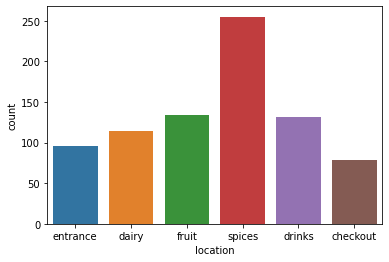

In [265]:
sns.countplot(data= df, x="location")

1. Calculate the total number of customers in each section

2. Calculate the total number of customers in each section over time

3. Display the number of customers at checkout over time

4. Calculate the time each customer spent in the market

5. Calculate the total number of customers in the supermarket over time.

In [267]:
# number of customers in each section
df.groupby(["location"])["customer_no"].count()

location
checkout     79
dairy       114
drinks      131
entrance     96
fruit       134
spices      255
Name: customer_no, dtype: int64

In [274]:
df.groupby("location")["customer_no"].count()

location
checkout     79
dairy       114
drinks      131
entrance     96
fruit       134
spices      255
Name: customer_no, dtype: int64

In [299]:
# number of customers at checkout over time

<AxesSubplot:xlabel='time_'>

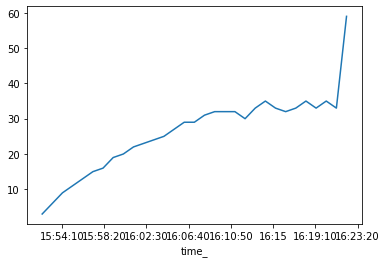

In [276]:
# total number of customers in each section over time
df.set_index("time_").groupby("time_")["location"].count().plot()

In [341]:
tttp = df.groupby(["location", "time_"]).sum()
# visualize how?
tttp.reset_index(inplace=True)
tttp.set_index("time_", inplace=True)

location
checkout    AxesSubplot(0.125,0.125;0.775x0.755)
dairy       AxesSubplot(0.125,0.125;0.775x0.755)
drinks      AxesSubplot(0.125,0.125;0.775x0.755)
entrance    AxesSubplot(0.125,0.125;0.775x0.755)
fruit       AxesSubplot(0.125,0.125;0.775x0.755)
spices      AxesSubplot(0.125,0.125;0.775x0.755)
Name: customer_no, dtype: object

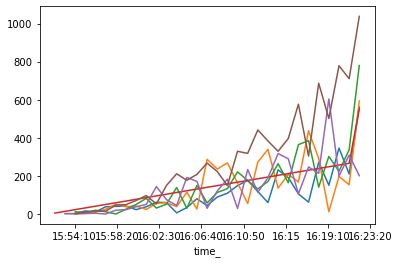

In [352]:
tttp.groupby("location")["customer_no"].plot()

<AxesSubplot:xlabel='time_', ylabel='count'>

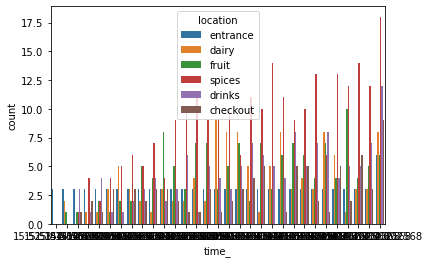

In [357]:
sns.countplot(data=df, x="time_", hue="location")


<AxesSubplot:xlabel='time_', ylabel='count'>

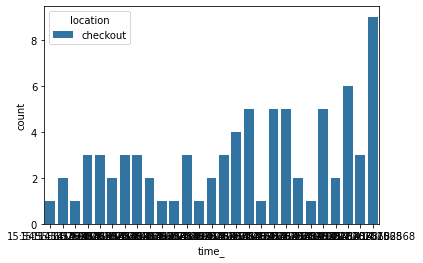

In [360]:
# number of customers at checkout over time
sns.countplot(data=df.loc[df["location"] == "checkout"], x="time_", hue = "location")

In [379]:
# time each customer spent in the market
